In [7]:
import os
import pandas as pd
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal
import geopandas as gpd
import descartes 
from shapely.geometry import Point, Polygon
from shapely import wkt


import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import fiona

#os.chdir('../../')
#os.chdir('../')
os.getcwd()

'C:\\Users\\leogo\\OneDrive\\Desktop\\PhD\\Analysis'

In [8]:
#Reading in all files and ensuring they are in a GeoDataFrame format
def create_geo_data_frame_from_point_dataset (dataframe, crs, name_of_lat_column, name_of_lon_column):
    latitude_not_null=dataframe.loc[:,name_of_lat_column].notnull()
    longitude_not_null=dataframe.loc[:,name_of_lon_column].notnull()
    dataframe=dataframe.loc[latitude_not_null&longitude_not_null,:]
    
    geometry=[Point(xy) for xy in zip(dataframe[name_of_lon_column], dataframe[name_of_lat_column])]
    dataframe = gpd.GeoDataFrame(dataframe, geometry=geometry,crs=crs)
    return dataframe;

# defining a coordinate reference system 
crs={'init' :'epsg:4326'}


points_rhomis_geodataframe=pd.read_csv(os.path.join("data","rhomis_data","RHoMIS_Indicators.csv"), encoding="latin1")
name_of_lat_column="GPS_LAT"
name_of_lon_column="GPS_LON"
points_rhomis_geodataframe=create_geo_data_frame_from_point_dataset(dataframe=points_rhomis_geodataframe,
                                                                   crs=crs,
                                                                   name_of_lat_column=name_of_lat_column,
                                                                   name_of_lon_column=name_of_lon_column)

grids_geodataframe=pd.read_csv(os.path.join("data","processed","hundred_km_grid_with_raster_info.csv"))
grids_geodataframe['geometry'] = grids_geodataframe['geometry'].apply(wkt.loads)
grids_geodataframe = gpd.GeoDataFrame(grids_geodataframe, geometry='geometry')
grids_geodataframe=gpd.GeoDataFrame(grids_geodataframe, geometry=grids_geodataframe["geometry"], crs=crs)

world_shapefile=gpd.read_file(os.path.join('data', 'shapefiles', 'World'))

In [9]:
grids_geodataframe=grids_geodataframe.drop_duplicates(subset=["geometry"])
world_shapefile=world_shapefile.drop_duplicates(subset=["geometry"])

In [10]:
def nesting_points_within_grids_within_countries(point_dataframe,point_ID,grid_dataframe,grid_ID,world_dataframe,country_ID):
    
    grid_overlay=gpd.overlay(world_dataframe,grid_dataframe, "identity")
    grid_overlay=pd.merge(grid_overlay, world_dataframe, how="left",on=country_ID, suffixes=["_grid","_country"])
        
    points_overlay=gpd.sjoin(grid_overlay.set_geometry("geometry_grid"),point_dataframe,op="contains")
    cols_to_merge = point_dataframe.columns.difference(points_overlay.columns).tolist()
    cols_to_merge.append(point_ID)    
    points_within_grid_within_country=pd.merge(points_overlay, point_dataframe[cols_to_merge], how="inner",on=point_ID, suffixes=["_grid","_point"])
    points_within_grid_within_country.columns=["geometry_point" if column_names=="geometry" else column_names for column_names in points_within_grid_within_country.columns]
    return points_within_grid_within_country;



In [11]:
points_within_grids_within_countries=nesting_points_within_grids_within_countries(point_dataframe=points_rhomis_geodataframe,
                                            point_ID="ID_HH",
                                            grid_dataframe=grids_geodataframe,
                                            grid_ID="FID",
                                            world_dataframe=world_shapefile,
                                            country_ID="CNTRY_NAME")




In [72]:
#points_within_grids_within_countries_dataframe.to_csv(os.path.join('data',"processed","points_within_grids_within_countries_100km.csv"))
points_within_grids_within_countries_single_geometry=points_within_grids_within_countries.drop(columns=["geometry_country","geometry_point"])
points_within_grids_within_countries_single_geometry.to_file(os.path.join('data',"processed","points_within_grids_within_countries_100km.geojson"), driver='GeoJSON') # at this point we only preserve the grid geometry. Will need to add point geometry when reading the file back in again (same with country boundaries)  

In [122]:
world_shapefile=gpd.read_file(os.path.join('data', 'shapefiles', 'World'))

points_within_grids_within_countries=gpd.read_file(os.path.join('data',"processed","points_within_grids_within_countries_100km.geojson"), driver='GeoJSON')
points_within_grids_within_countries.columns=["geometry_grid" if column_names=="geometry" else column_names for column_names in points_within_grids_within_countries.columns]
point_geometry=[Point(xy) for xy in zip(points_within_grids_within_countries["GPS_LON"], points_within_grids_within_countries["GPS_LAT"])]
points_within_grids_within_countries["geometry_point"]=point_geometry




In [123]:
#merging country geometries with nested geo_file
cols_to_merge = ["CNTRY_NAME","geometry"]
points_within_grids_within_countries=pd.merge(points_within_grids_within_countries, world_shapefile[cols_to_merge], how="inner",on="CNTRY_NAME", suffixes=["",""])
points_within_grids_within_countries.columns=["geometry_country" if column_names=="geometry" else column_names for column_names in points_within_grids_within_countries.columns]



0        POLYGON ((0.91797 10.99640, 0.81194 10.99694, ...
1        POLYGON ((0.91797 10.99640, 0.81194 10.99694, ...
2        POLYGON ((0.91797 10.99640, 0.81194 10.99694, ...
3        POLYGON ((0.91797 10.99640, 0.81194 10.99694, ...
4        POLYGON ((0.91797 10.99640, 0.81194 10.99694, ...
                               ...                        
14746    POLYGON ((-69.56750 -10.95056, -69.56844 -10.9...
14747    POLYGON ((-69.56750 -10.95056, -69.56844 -10.9...
14748    POLYGON ((-69.56750 -10.95056, -69.56844 -10.9...
14749    POLYGON ((-69.56750 -10.95056, -69.56844 -10.9...
14750    POLYGON ((-69.56750 -10.95056, -69.56844 -10.9...
Name: geometry_country, Length: 14751, dtype: geometry

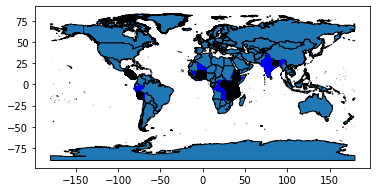

In [125]:
fig, ax= plt.subplots()

world_shapefile.plot(ax=ax,edgecolor="black")
points_within_grids_within_countries.set_geometry("geometry_country").plot(ax=ax, color="blue",alpha=0.5)
points_within_grids_within_countries.set_geometry("geometry_grid").plot(ax=ax, color="green",alpha=0.5)
points_within_grids_within_countries.set_geometry("geometry_point").plot(ax=ax, color="black")
plt.show()

In [219]:
# finding countries in the continent
continent="Africa"
world_shapefile=gpd.read_file(os.path.join('data', 'shapefiles', 'World'))
world_geopanda = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #continents dataframe
continent_shapefile=world_geopanda.loc[world_geopanda["continent"]==continent,["continent","geometry"]]
continent_shapefile["geometry"]=continent_shapefile.envelope
continent_shapefile.columns=["geometry_continent" if col_name=="geometry" else col_name for col_name in continent_shapefile.columns]
#subset_world_shapefile=gpd.overlay(world_shapefile.set_geometry("geometry"), continent_shapefile.set_geometry("geometry_continent"), how='intersection')
subset_world_shapefile=gpd.sjoin(world_shapefile.set_geometry("geometry"), continent_shapefile.set_geometry("geometry_continent"), how='inner')

countries=subset_world_shapefile["CNTRY_NAME"].unique()


# Getting rid of some european countries
countries_to_exclude=["Portugal", "Spain", "Gibraltar", "Gaza Strip", "Israel", "Jordan", "West Bank"]
final_countries=pd.Series(countries).isin(countries_to_exclude)==False
final_countries=countries[final_countries]


#subsetting final dataframe
subset_world_shapefile=subset_world_shapefile.loc[subset_world_shapefile["CNTRY_NAME"].isin(final_countries),:]
subset_df=points_within_grids_within_countries["CNTRY_NAME"].isin(final_countries)
points_within_grids_within_countries=points_within_grids_within_countries.loc[subset_df,:]

In [220]:
subset_world_shapefile.columns

Index(['OBJECTID', 'CNTRY_NAME', 'geometry', 'index_right', 'continent'], dtype='object')

In [221]:
subset_world_shapefile.columns

Index(['OBJECTID', 'CNTRY_NAME', 'geometry', 'index_right', 'continent'], dtype='object')

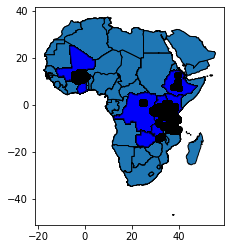

In [226]:


fig, ax= plt.subplots()

subset_world_shapefile.plot(ax=ax,edgecolor="black")
points_within_grids_within_countries.set_geometry("geometry_country").plot(ax=ax, edgecolor="black",color="blue",alpha=0.2)
points_within_grids_within_countries.set_geometry("geometry_grid").plot(ax=ax, color="green",alpha=0.5)
points_within_grids_within_countries.set_geometry("geometry_point").plot(ax=ax, color="black")
plt.show()

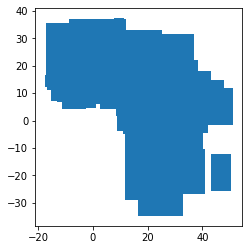

In [169]:
def remove_outliers_with_interquartile_range(column):
    quartile_1=column.quantile(0.25)
    quartile_3=column.quantile(0.75)
    interquartile_range=quartile_3-quartile_1
    
    lower_limit=quartile_1-1.5*interquartile_range
    upper_limit=quartile_3+1.5*interquartile_range
    
    column=column[(column>lower_limit) & (column<upper_limit)]
    return column;


len(geographicall_nested_dataset["total_income_USD_PPP_pHH_Yr"])
#sns.distplot(geographicall_nested_dataset["Food_Availability_kCal_MAE_day"].dropna())

25952

In [170]:
points_within_grids_within_countries.describe()

,OBJECTID_grid,Unnamed: 0,FID,mean_education,median_education,std_education,majority,mean_technological_capital,median_technological_capital,std_technological_capital,...,value_livestock_prod_consumed_USD_PPP_pHH_Yr_point,Market_Orientation_point,Livestock_Orientation_point,Food_Availability_kCal_MAE_day_point,Food_Self_Sufficiency_kCal_MAE_day_point,NrofMonthsWildFoodCons_point,GHGEmissions_point,Gender_MaleControl_point,Gender_FemaleControl_point,NFertInput_point
count,14751.000000,14751.000000,14751.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,...,1.475100e+04,14400.000000,14400.000000,1.450200e+04,1.469200e+04,14751.000000,6.116000e+03,12192.000000,12192.000000,6116.000000
mean,158.530473,5803.152193,5803.152193,0.058912,0.049116,0.112902,0.030094,-0.075534,-0.057011,0.213585,...,7.348941e+02,0.361860,0.202664,1.860771e+05,9.037182e+03,1.281811,2.699861e+04,0.745323,0.254677,371.455235
std,72.390706,4614.806347,4614.806347,0.338985,0.366448,0.097171,0.367734,0.282015,0.280232,0.121799,...,6.545478e+04,0.349848,0.292020,1.189282e+07,3.087136e+05,2.363816,7.639528e+04,0.332749,0.332749,1239.331313
min,35.000000,109.000000,109.000000,-0.746928,-0.867469,0.000000,-0.867469,-0.862406,-0.698689,0.056981,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,4.172000e-02,0.000000,0.000000,0.000000
25%,83.000000,1739.000000,1739.000000,-0.278877,-0.239923,0.043593,-0.239923,-0.290447,-0.295168,0.111609,...,0.000000e+00,0.000143,0.000000,6.718832e+02,2.586189e+02,0.000000,2.572567e+03,0.538879,0.000000,50.000000
50%,193.000000,5783.000000,5783.000000,0.109809,0.109809,0.106372,0.109809,-0.020465,-0.015511,0.168827,...,0.000000e+00,0.284930,0.021782,2.089467e+03,8.017545e+02,0.000000,1.332227e+04,0.967280,0.032720,100.000000
75%,229.000000,9596.000000,9596.000000,0.409082,0.422883,0.173097,0.362108,0.123378,0.133400,0.307529,...,3.048339e+01,0.675357,0.341577,6.107103e+03,2.075928e+03,2.000000,2.951422e+04,1.000000,0.461121,250.000000
max,250.000000,22141.000000,22141.000000,0.577669,0.711208,0.549530,0.990111,0.588510,0.604076,0.586302,...,7.943184e+06,1.000000,1.000000,1.166834e+09,2.705071e+07,12.000000,2.717704e+06,1.000000,1.000000,32500.000000


In [171]:
points_within_grids_within_countries["mean_education"].dtype

dtype('float64')

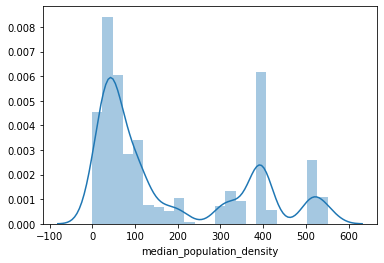

In [182]:
sns.distplot(remove_outliers_with_interquartile_range(points_within_grids_within_countries["median_population_density"].dropna()))

In [219]:
ymax

37.349994411766545

In [ ]:
countries_in_africa=["Algeria",
                     "Angola",
                     "Benin",
                     "Botswana",
                    "Burundi",
                    "Burkina Faso",
                    "Zaire",
                     "Chad",
                    "Comoros",
                    "Cameroon",
                    "Central African Republic",
                    "Congo",
                    "Djibouti",
                    "Egypt",
                    "Equitorial Guinea",
                    "Eritrea",
                    "Ethiopia",
                    "Gambia, The",
                    "Gabon",
                    "Guinea",
                    "Kenya"
                    ]